In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import os
from tqdm import tqdm

In [2]:
# os.makedirs('new_data', exist_ok=True)
# for year in tqdm(range(2000, 2024)):
#     pd.read_html(f'https://www.basketball-reference.com/leagues/NBA_{year}_totals.html')[0].to_csv(f'new_data/player_{year}.csv', index=False)

In [3]:
def process_year(year):

    # load data
    data = pd.read_csv(f'new_data/player_{year}.csv')

    # get rid of unnecessary rows
    data = data[(data['Player'] != 'Player') & (data['Pos'] != 'Pos')]

    # set season
    
    data['Season'] = year
    data['Trend'] = year - 2000

    first_column = data.pop('Season')
    data.insert(0, 'Season', first_column) 

    # convert data types to float
    convert_dict = {col: float for col in ['Age', 'G', 'GS', 'MP', 'FG', 'FGA', 'FG%',
        '3P', '3PA', '3P%', '2P', '2PA', '2P%', 'eFG%', 'FT', 'FTA', 'FT%',
        'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS']
        }
    data = data.astype(
        convert_dict
        
    )

    # subtract points made from 3 from total points
    data['PTS'] = data['PTS'] - 3* data['3P']

    # drop duplicated rows for players who played for multiple teams, keep the last team they played for
    data = data.sort_values(by='G', ascending=False)
    data = data.drop_duplicates(subset='Player')
    data.reset_index(drop=True, inplace=True)



    game_played_thredhold = data.groupby('Tm').max()['G'].to_dict()

    # drop players who played less than 1/3 of the player who played the most games for that team
    for team in game_played_thredhold:
        data = data[~((data['Tm'] == team) & (data['G'] < game_played_thredhold[team]/3))]


    return data

In [4]:
players = pd.DataFrame()
for year in tqdm(range(2000, 2024)):
    cur_year = process_year(year)
    players = pd.concat([players, cur_year], ignore_index=True, axis=0)
players

100%|██████████| 24/24 [00:00<00:00, 60.62it/s]


,Season,Rk,Player,Pos,Age,Tm,G,GS,MP,FG,...,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Trend
0,2000,144,Chris Gatling,PF,32.0,TOT,85.0,0.0,1811.0,365.0,...,154.0,348.0,502.0,71.0,82.0,23.0,169.0,246.0,960.0,0
1,2000,290,Johnny Newman,SF,36.0,NJN,82.0,9.0,1763.0,278.0,...,39.0,115.0,154.0,65.0,53.0,11.0,89.0,207.0,604.0,0
2,2000,421,Chris Whitney,PG,28.0,WAS,82.0,15.0,1627.0,217.0,...,20.0,114.0,134.0,313.0,55.0,5.0,107.0,166.0,354.0,0
3,2000,154,A.C. Green,PF,36.0,LAL,82.0,82.0,1929.0,173.0,...,160.0,326.0,486.0,80.0,53.0,18.0,53.0,127.0,410.0,0
4,2000,286,Dikembe Mutombo*,C,33.0,ATL,82.0,82.0,2984.0,322.0,...,304.0,853.0,1157.0,105.0,27.0,269.0,174.0,248.0,942.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9087,2023,26,Dominick Barlow,PF,19.0,SAS,28.0,0.0,408.0,46.0,...,46.0,56.0,102.0,24.0,10.0,19.0,15.0,56.0,110.0,23
9088,2023,111,Johnny Davis,SG,20.0,WAS,28.0,5.0,423.0,66.0,...,10.0,55.0,65.0,28.0,10.0,8.0,17.0,48.0,112.0,23
9089,2023,159,Luka Garza,C,24.0,MIN,28.0,0.0,243.0,63.0,...,33.0,30.0,63.0,18.0,3.0,2.0,14.0,43.0,139.0,23
9090,2023,370,Chuma Okeke,SF,24.0,ORL,27.0,8.0,518.0,43.0,...,26.0,70.0,96.0,37.0,19.0,11.0,17.0,40.0,50.0,23


In [5]:
players.columns

Index(['Season', 'Rk', 'Player', 'Pos', 'Age', 'Tm', 'G', 'GS', 'MP', 'FG',
       'FGA', 'FG%', '3P', '3PA', '3P%', '2P', '2PA', '2P%', 'eFG%', 'FT',
       'FTA', 'FT%', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF',
       'PTS', 'Trend'],
      dtype='object')

In [6]:
salaries = pd.read_csv(os.path.join('data', 'nba-salaries.csv'))
salaries

,rank,name,position,team,salary,season
0,1,Shaquille O'Neal,C,Los Angeles Lakers,17142000,2000
1,2,Kevin Garnett,PF,Minnesota Timberwolves,16806000,2000
2,3,Alonzo Mourning,C,Miami Heat,15004000,2000
3,4,Juwan Howard,PF,Washington Wizards,15000000,2000
4,5,Scottie Pippen,SF,Portland Trail Blazers,14795000,2000
...,...,...,...,...,...,...
9451,524,Jimmer Fredette,G,Phoenix Suns,208509,2020
9452,525,Jontay Porter,PF,Memphis Grizzlies,197933,2020
9453,526,Anthony Tolliver,PF,Memphis Grizzlies,183115,2020
9454,527,Tyler Johnson,SG,Phoenix Suns,183115,2020


In [7]:
df = players.merge(salaries, left_on=['Player', 'Season'], right_on=['name', 'season'])
seasons = pd.get_dummies(df['Season'], drop_first=True, prefix="season")
teams = pd.get_dummies(df['Tm'], drop_first=True, prefix="team")
positions = pd.get_dummies(df['Pos'], drop_first=True, prefix="position")
df = pd.concat([df, seasons, teams, positions], axis=1)
df
## old data only has 5266 after merging, new data has 7441

,Season,Rk,Player,Pos,Age,Tm,G,GS,MP,FG,...,position_PG-SF,position_PG-SG,position_SF,position_SF-C,position_SF-PF,position_SF-SG,position_SG,position_SG-PF,position_SG-PG,position_SG-SF
0,2000,143,Pat Garrity,SF,23.0,ORL,82.0,1.0,1479.0,258.0,...,0,0,1,0,0,0,0,0,0,0
1,2000,135,Rick Fox,SF,30.0,LAL,82.0,1.0,1473.0,206.0,...,0,0,1,0,0,0,0,0,0,0
2,2000,292,Dirk Nowitzki,PF,21.0,DAL,82.0,81.0,2938.0,515.0,...,0,0,0,0,0,0,0,0,0,0
3,2000,111,Michael Dickerson,SG,24.0,VAN,82.0,82.0,3103.0,554.0,...,0,0,0,0,0,0,1,0,0,0
4,2000,99,Baron Davis,PG,20.0,CHH,82.0,0.0,1523.0,182.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6224,2020,400,Norvel Pelle,C,26.0,PHI,24.0,0.0,232.0,25.0,...,0,0,0,0,0,0,0,0,0,0
6225,2020,88,DeMarre Carroll,SF-C,33.0,TOT,24.0,0.0,290.0,25.0,...,0,0,0,1,0,0,0,0,0,0
6226,2020,288,Jake Layman,SF,25.0,MIN,23.0,2.0,505.0,81.0,...,0,0,1,0,0,0,0,0,0,0
6227,2020,31,Nicolas Batum,SF,31.0,CHO,22.0,3.0,505.0,28.0,...,0,0,1,0,0,0,0,0,0,0


In [8]:
# Shfit the salary to the next year

df = df.sort_values(by=['Player', 'Season'])

# Group by 'Player' and then shift the 'salary' column by 1 to get the previous year's salary
df['last_year_salary'] = df.groupby('Player')['salary'].shift(1)

# Replace the NaN values for players who did not play last year
df['last_year_salary'] = df['last_year_salary'].replace({np.nan: None}).astype(float)

In [9]:
df

,Season,Rk,Player,Pos,Age,Tm,G,GS,MP,FG,...,position_PG-SG,position_SF,position_SF-C,position_SF-PF,position_SF-SG,position_SG,position_SG-PF,position_SG-PG,position_SG-SF,last_year_salary
148,2001,152,A.C. Green,PF,37.0,MIA,82.0,1.0,1411.0,144.0,...,0,0,0,0,0,0,0,0,0,NaN
400,2001,155,A.J. Guyton,PG,22.0,CHI,33.0,8.0,630.0,78.0,...,0,0,0,0,0,0,0,0,0,NaN
667,2002,160,A.J. Guyton,PG,23.0,CHI,45.0,6.0,607.0,88.0,...,0,0,0,0,0,0,0,0,0,316000.0
2678,2010,335,A.J. Price,PG,23.0,IND,56.0,2.0,865.0,145.0,...,0,0,0,0,0,0,0,0,0,NaN
3039,2011,339,A.J. Price,PG,24.0,IND,50.0,0.0,795.0,114.0,...,0,0,0,0,0,0,0,0,0,457588.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1558,2007,195,Zydrunas Ilgauskas,C,31.0,CLE,78.0,78.0,2130.0,385.0,...,0,0,0,0,0,0,0,0,0,8743238.0
1946,2008,201,Zydrunas Ilgauskas,C,32.0,CLE,73.0,73.0,2222.0,417.0,...,0,0,0,0,0,0,0,0,0,9442697.0
2311,2009,199,Zydrunas Ilgauskas,C,33.0,CLE,65.0,65.0,1765.0,342.0,...,0,0,0,0,0,0,0,0,0,10142156.0
2645,2010,213,Zydrunas Ilgauskas,C,34.0,CLE,64.0,6.0,1339.0,194.0,...,0,0,0,0,0,0,0,0,0,10841615.0


In [10]:
df['G'].describe()

count    6229.000000
mean       63.080751
std        15.861770
min        20.000000
25%        52.000000
50%        66.000000
75%        77.000000
max        85.000000
Name: G, dtype: float64

In [11]:
# list(df.columns)

In [12]:
df['3PPerMP'] = df['3P'] / df['MP']
df['PTSPerMP'] = df['PTS'] / df['MP']
df['TRBPerMP'] = df['TRB'] / df['MP']
df['ASTPerMP'] = df['AST'] / df['MP']
df['PFPerMP'] = df['PF'] / df['MP']
df['STLPerMP'] = df['STL'] / df['MP']

In [13]:
df[['3PPerMP', 'PTSPerMP', 'TRBPerMP', 'ASTPerMP', 'PFPerMP', 'STLPerMP']].describe()

,3PPerMP,PTSPerMP,TRBPerMP,ASTPerMP,PFPerMP,STLPerMP
count,6229.000000,6229.000000,6229.000000,6229.000000,6229.000000,6229.000000
mean,0.028361,0.300186,0.176331,0.083293,0.094381,0.030836
std,0.026015,0.117338,0.078301,0.055249,0.033419,0.011979
min,0.000000,0.016086,0.043417,0.000000,0.025463,0.000000
25%,0.001164,0.215000,0.110488,0.043347,0.070500,0.022265
50%,0.025974,0.289300,0.159501,0.065186,0.087821,0.029204
75%,0.047847,0.373596,0.233370,0.111361,0.112490,0.037551
max,0.151866,0.829421,0.488053,0.330706,0.323944,0.115789


In [14]:
df[(df['Player']=='Damion James') & (df['Season']==2013)]

,Season,Rk,Player,Pos,Age,Tm,G,GS,MP,FG,...,position_SG-PF,position_SG-PG,position_SG-SF,last_year_salary,3PPerMP,PTSPerMP,TRBPerMP,ASTPerMP,PFPerMP,STLPerMP


<AxesSubplot:ylabel='Frequency'>

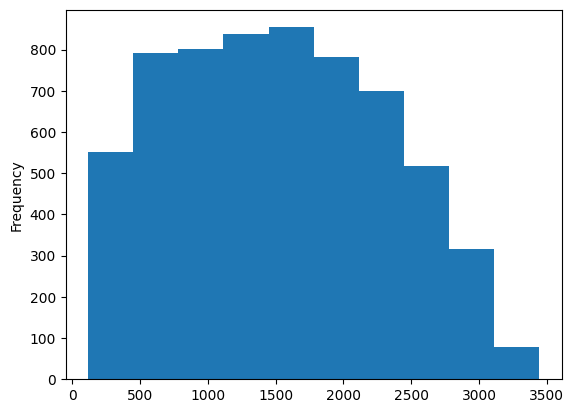

In [15]:
df['MP'].plot(kind='hist')

In [16]:
display(df[df['TRBPerMP'] == np.inf][['TRB', 'MP', 'Player', 'Season']])

df = df[~((df['Player']=='Damion James') & (df['Season']==2013))]
df

,TRB,MP,Player,Season


,Season,Rk,Player,Pos,Age,Tm,G,GS,MP,FG,...,position_SG-PF,position_SG-PG,position_SG-SF,last_year_salary,3PPerMP,PTSPerMP,TRBPerMP,ASTPerMP,PFPerMP,STLPerMP
148,2001,152,A.C. Green,PF,37.0,MIA,82.0,1.0,1411.0,144.0,...,0,0,0,NaN,0.000000,0.260099,0.221828,0.027640,0.084337,0.021262
400,2001,155,A.J. Guyton,PG,22.0,CHI,33.0,8.0,630.0,78.0,...,0,0,0,NaN,0.042857,0.185714,0.057143,0.101587,0.055556,0.014286
667,2002,160,A.J. Guyton,PG,23.0,CHI,45.0,6.0,607.0,88.0,...,0,0,0,316000.0,0.075783,0.174629,0.072488,0.133443,0.037891,0.016474
2678,2010,335,A.J. Price,PG,23.0,IND,56.0,2.0,865.0,145.0,...,0,0,0,NaN,0.069364,0.265896,0.101734,0.122543,0.061272,0.040462
3039,2011,339,A.J. Price,PG,24.0,IND,50.0,0.0,795.0,114.0,...,0,0,0,457588.0,0.051572,0.251572,0.090566,0.139623,0.076730,0.036478
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1558,2007,195,Zydrunas Ilgauskas,C,31.0,CLE,78.0,78.0,2130.0,385.0,...,0,0,0,8743238.0,0.000000,0.434272,0.281221,0.057746,0.120657,0.022535
1946,2008,201,Zydrunas Ilgauskas,C,32.0,CLE,73.0,73.0,2222.0,417.0,...,0,0,0,9442697.0,0.000000,0.463096,0.306931,0.046805,0.111161,0.015302
2311,2009,199,Zydrunas Ilgauskas,C,33.0,CLE,65.0,65.0,1765.0,342.0,...,0,0,0,10142156.0,0.008499,0.449292,0.277620,0.036261,0.103683,0.015864
2645,2010,213,Zydrunas Ilgauskas,C,34.0,CLE,64.0,6.0,1339.0,194.0,...,0,0,0,10841615.0,0.008215,0.329350,0.257655,0.035848,0.136669,0.010456


In [17]:
df['TRB'].describe(), df['MP'].describe()

(count    6229.000000
 mean      265.550169
 std       186.830192
 min         8.000000
 25%       128.000000
 50%       223.000000
 75%       356.000000
 max      1247.000000
 Name: TRB, dtype: float64,
 count    6229.000000
 mean     1524.932092
 std       780.198514
 min       119.000000
 25%       868.000000
 50%      1498.000000
 75%      2134.000000
 max      3443.000000
 Name: MP, dtype: float64)

In [18]:
df[['3PPerMP', 'PTSPerMP', 'TRBPerMP', 'ASTPerMP', 'PFPerMP', 'STLPerMP']].describe()

,3PPerMP,PTSPerMP,TRBPerMP,ASTPerMP,PFPerMP,STLPerMP
count,6229.000000,6229.000000,6229.000000,6229.000000,6229.000000,6229.000000
mean,0.028361,0.300186,0.176331,0.083293,0.094381,0.030836
std,0.026015,0.117338,0.078301,0.055249,0.033419,0.011979
min,0.000000,0.016086,0.043417,0.000000,0.025463,0.000000
25%,0.001164,0.215000,0.110488,0.043347,0.070500,0.022265
50%,0.025974,0.289300,0.159501,0.065186,0.087821,0.029204
75%,0.047847,0.373596,0.233370,0.111361,0.112490,0.037551
max,0.151866,0.829421,0.488053,0.330706,0.323944,0.115789


In [19]:
# interaction terms
for year in range(2001, 2021):
    df[f'3PPerMPxseason_{year}'] = df.loc[:, '3PPerMP'] * df.loc[:, f'season_{year}']
df['3PPerMPxTrend'] = df['3PPerMP'] * df['Trend']

In [20]:
list(df.columns)

['Season',
 'Rk',
 'Player',
 'Pos',
 'Age',
 'Tm',
 'G',
 'GS',
 'MP',
 'FG',
 'FGA',
 'FG%',
 '3P',
 '3PA',
 '3P%',
 '2P',
 '2PA',
 '2P%',
 'eFG%',
 'FT',
 'FTA',
 'FT%',
 'ORB',
 'DRB',
 'TRB',
 'AST',
 'STL',
 'BLK',
 'TOV',
 'PF',
 'PTS',
 'Trend',
 'rank',
 'name',
 'position',
 'team',
 'salary',
 'season',
 'season_2001',
 'season_2002',
 'season_2003',
 'season_2004',
 'season_2005',
 'season_2006',
 'season_2007',
 'season_2008',
 'season_2009',
 'season_2010',
 'season_2011',
 'season_2012',
 'season_2013',
 'season_2014',
 'season_2015',
 'season_2016',
 'season_2017',
 'season_2018',
 'season_2019',
 'season_2020',
 'team_BOS',
 'team_BRK',
 'team_CHA',
 'team_CHH',
 'team_CHI',
 'team_CHO',
 'team_CLE',
 'team_DAL',
 'team_DEN',
 'team_DET',
 'team_GSW',
 'team_HOU',
 'team_IND',
 'team_LAC',
 'team_LAL',
 'team_MEM',
 'team_MIA',
 'team_MIL',
 'team_MIN',
 'team_NJN',
 'team_NOH',
 'team_NOK',
 'team_NOP',
 'team_NYK',
 'team_OKC',
 'team_ORL',
 'team_PHI',
 'team_PHO',


In [21]:
# baseline model: all stats and this year's salary


independent_vars = [
    'GS', '3PPerMP', 'PTSPerMP', 'TRBPerMP', 'ASTPerMP', 'PFPerMP', 'STLPerMP',

 'season_2001',
 'season_2002',
 'season_2003',
 'season_2004',
 'season_2005',
 'season_2006',
 'season_2007',
 'season_2008',
 'season_2009',
 'season_2010',
 'season_2011',
 'season_2012',
 'season_2013',
 'season_2014',
 'season_2015',
 'season_2016',
 'season_2017',
 'season_2018',
 'season_2019',
 'season_2020',
 '3PPerMPxseason_2001',
 '3PPerMPxseason_2002',
 '3PPerMPxseason_2003',
 '3PPerMPxseason_2004',
 '3PPerMPxseason_2005',
 '3PPerMPxseason_2006',
 '3PPerMPxseason_2007',
 '3PPerMPxseason_2008',
 '3PPerMPxseason_2009',
 '3PPerMPxseason_2010',
 '3PPerMPxseason_2011',
 '3PPerMPxseason_2012',
 '3PPerMPxseason_2013',
 '3PPerMPxseason_2014',
 '3PPerMPxseason_2015',
 '3PPerMPxseason_2016',
 '3PPerMPxseason_2017',
 '3PPerMPxseason_2018',
 '3PPerMPxseason_2019',
 '3PPerMPxseason_2020'
       ]


#ThreePointersMade/Seconds

X = df[independent_vars]  # Independent variables
y = df['salary']  # Dependent variable

# Adding a constant term for the intercept
X = sm.add_constant(X)

# Fitting the model
model = sm.OLS(y, X).fit(cov_type='HC1')

# Getting the summary of the model
model_summary = model.summary()
model_summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 salary   R-squared:                       0.386
Model:                            OLS   Adj. R-squared:                  0.381
Method:                 Least Squares   F-statistic:                     45.90
Date:                Wed, 01 Nov 2023   Prob (F-statistic):               0.00
Time:                        19:03:14   Log-Likelihood:            -1.0397e+05
No. Observations:                6229   AIC:                         2.080e+05
Df Residuals:                    6181   BIC:                         2.084e+05
Df Model:                          47                                         
Covariance Type:                  HC1                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const               -4.093e+06   5.96e+05     -6.869      0.000   -5.26e+06   -2.93e+06
GS                   5.313e+04   2143.635     24.786      0.000    4.89e+04    5.73e+04
3PPerMP              5.847e+06   1.15e+07      0.506      0.613   -1.68e+07    2.85e+07
PTSPerMP             1.067e+07   6.52e+05     16.372      0.000    9.39e+06    1.19e+07
TRBPerMP              1.76e+07   1.22e+06     14.448      0.000    1.52e+07       2e+07
ASTPerMP             1.623e+07   1.51e+06     10.736      0.000    1.33e+07    1.92e+07
PFPerMP             -1.603e+07   2.02e+06     -7.922      0.000      -2e+07   -1.21e+07
STLPerMP             -1.83e+07   4.88e+06     -3.753      0.000   -2.79e+07   -8.74e+06
season_2001         -1.079e+05   4.29e+05     -0.251      0.801   -9.48e+05    7.33e+05
season_2002          -3.05e+05    4.3e+05     -0.709      0.479   -1.15e+06    5.39e+05
season_2003          5.596e+05   5.06e+05      1.107      0.268   -4.31e+05    1.55e+06
season_2004           1.07e+06   5.86e+05      1.826      0.068   -7.85e+04    2.22e+06
season_2005          2.426e+06   6.59e+05      3.682      0.000    1.13e+06    3.72e+06
season_2006          6.506e+05   4.31e+05      1.510      0.131   -1.94e+05    1.49e+06
season_2007           3.77e+05   4.24e+05      0.889      0.374   -4.54e+05    1.21e+06
season_2008          1.398e+05   4.52e+05      0.309      0.757   -7.45e+05    1.03e+06
season_2009           3.28e+05   4.63e+05      0.708      0.479    -5.8e+05    1.24e+06
season_2010           2.75e+05   4.59e+05      0.600      0.549   -6.24e+05    1.17e+06
season_2011          5.077e+05   4.54e+05      1.119      0.263   -3.82e+05     1.4e+06
season_2012          8.314e+05   4.47e+05      1.861      0.063    -4.4e+04    1.71e+06
season_2013          4.263e+05   4.53e+05      0.941      0.347   -4.62e+05    1.31e+06
season_2014          6.601e+05   4.88e+05      1.354      0.176   -2.96e+05    1.62e+06
season_2015          2.463e+05   4.75e+05      0.518      0.604   -6.86e+05    1.18e+06
season_2016          5.045e+05    5.3e+05      0.952      0.341   -5.34e+05    1.54e+06
season_2017          1.823e+06   6.26e+05      2.914      0.004    5.97e+05    3.05e+06
season_2018          1.872e+06    7.6e+05      2.462      0.014    3.82e+05    3.36e+06
season_2019          1.228e+06   8.15e+05      1.506      0.132    -3.7e+05    2.83e+06
season_2020          1.683e+06      8e+05      2.103      0.035    1.15e+05    3.25e+06
3PPerMPxseason_2001  1.635e+07   1.38e+07      1.182      0.237   -1.08e+07    4.35e+07
3PPerMPxseason_2002   1.84e+07   1.35e+07      1.359      0.174   -8.14e+06    4.49e+07
3PPerMPxseason_2003  1.324e+07   1.73e+07      0.767      0.443   -2.06e+07    4.71e+07
3PPerMPxseason_2004  2.918e+07   2.03e+07      1.439      0.150   -1.06e+07    6.89e+07
3PP

In [22]:
df[['GS', '3PPerMP', 'PTSPerMP', 'TRBPerMP', 'ASTPerMP', 'PFPerMP', 'STLPerMP']].corr()

,GS,3PPerMP,PTSPerMP,TRBPerMP,ASTPerMP,PFPerMP,STLPerMP
GS,1.000000,0.040392,0.356852,0.054862,0.189513,-0.354650,0.065520
3PPerMP,0.040392,1.000000,-0.319971,-0.536450,0.243822,-0.441078,0.083838
PTSPerMP,0.356852,-0.319971,1.000000,0.322815,0.094757,-0.062403,-0.008101
TRBPerMP,0.054862,-0.536450,0.322815,1.000000,-0.471909,0.467688,-0.223947
ASTPerMP,0.189513,0.243822,0.094757,-0.471909,1.000000,-0.412389,0.404647
PFPerMP,-0.354650,-0.441078,-0.062403,0.467688,-0.412389,1.000000,-0.137562
STLPerMP,0.065520,0.083838,-0.008101,-0.223947,0.404647,-0.137562,1.000000


In [23]:
# model2: all stats and last year's salary


independent_vars = [
    'GS', '3PPerMP', 'PTSPerMP', 'TRBPerMP', 'ASTPerMP', 'PFPerMP', 'STLPerMP',

 'season_2001',
 'season_2002',
 'season_2003',
 'season_2004',
 'season_2005',
 'season_2006',
 'season_2007',
 'season_2008',
 'season_2009',
 'season_2010',
 'season_2011',
 'season_2012',
 'season_2013',
 'season_2014',
 'season_2015',
 'season_2016',
 'season_2017',
 'season_2018',
 'season_2019',
 'season_2020',
 '3PPerMPxseason_2001',
 '3PPerMPxseason_2002',
 '3PPerMPxseason_2003',
 '3PPerMPxseason_2004',
 '3PPerMPxseason_2005',
 '3PPerMPxseason_2006',
 '3PPerMPxseason_2007',
 '3PPerMPxseason_2008',
 '3PPerMPxseason_2009',
 '3PPerMPxseason_2010',
 '3PPerMPxseason_2011',
 '3PPerMPxseason_2012',
 '3PPerMPxseason_2013',
 '3PPerMPxseason_2014',
 '3PPerMPxseason_2015',
 '3PPerMPxseason_2016',
 '3PPerMPxseason_2017',
 '3PPerMPxseason_2018',
 '3PPerMPxseason_2019',
 '3PPerMPxseason_2020'
       ]

new_df = df.copy()
new_df = new_df.dropna(subset=['last_year_salary'])

#ThreePointersMade/Seconds

X = new_df[independent_vars]  # Independent variables
y = new_df['last_year_salary']  # Dependent variable

# Adding a constant term for the intercept
X = sm.add_constant(X)

# Fitting the model
model = sm.OLS(y, X).fit(cov_type='HC1')

# Getting the summary of the model
model_summary = model.summary()
model_summary

/Users/weiyueli/opt/anaconda3/envs/nba3/lib/python3.9/site-packages/statsmodels/base/model.py:1888: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 47, but rank is 46
  warnings.warn('covariance of constraints does not have full '


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       last_year_salary   R-squared:                       0.287
Model:                            OLS   Adj. R-squared:                  0.280
Method:                 Least Squares   F-statistic:                     169.7
Date:                Wed, 01 Nov 2023   Prob (F-statistic):               0.00
Time:                        19:03:14   Log-Likelihood:                -83046.
No. Observations:                4965   AIC:                         1.662e+05
Df Residuals:                    4919   BIC:                         1.665e+05
Df Model:                          45                                         
Covariance Type:                  HC1                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const               -1.321e+06    4.9e+05     -2.694      0.007   -2.28e+06    -3.6e+05
GS                   3.615e+04   2448.585     14.765      0.000    3.14e+04     4.1e+04
3PPerMP              2.741e+07    3.4e+06      8.052      0.000    2.07e+07    3.41e+07
PTSPerMP             7.931e+06   7.13e+05     11.125      0.000    6.53e+06    9.33e+06
TRBPerMP             1.671e+07   1.37e+06     12.239      0.000     1.4e+07    1.94e+07
ASTPerMP             1.584e+07   1.63e+06      9.693      0.000    1.26e+07     1.9e+07
PFPerMP             -1.557e+07   2.59e+06     -6.019      0.000   -2.06e+07   -1.05e+07
STLPerMP            -2.856e+07   5.72e+06     -4.995      0.000   -3.98e+07   -1.74e+07
season_2001         -7.396e+05   3.76e+05     -1.965      0.049   -1.48e+06   -2021.511
season_2002         -1.204e+06   2.57e+05     -4.685      0.000   -1.71e+06      -7e+05
season_2003         -8.562e+05   2.95e+05     -2.902      0.004   -1.43e+06   -2.78e+05
season_2004         -2.397e+05   3.99e+05     -0.600      0.548   -1.02e+06    5.43e+05
season_2005          9.001e+05   4.96e+05      1.813      0.070   -7.28e+04    1.87e+06
season_2006         -1.988e+04    4.1e+05     -0.049      0.961   -8.23e+05    7.83e+05
season_2007         -8.105e+05   2.65e+05     -3.061      0.002   -1.33e+06   -2.91e+05
season_2008         -8.455e+05   3.04e+05     -2.778      0.005   -1.44e+06   -2.49e+05
season_2009         -2.354e+05   3.34e+05     -0.705      0.481    -8.9e+05    4.19e+05
season_2010         -4.994e+05   3.35e+05     -1.491      0.136   -1.16e+06    1.57e+05
season_2011         -3.632e+05   2.98e+05     -1.221      0.222   -9.47e+05     2.2e+05
season_2012          2.812e+05    3.6e+05      0.781      0.435   -4.25e+05    9.87e+05
season_2013         -3.233e+05   3.24e+05     -0.996      0.319   -9.59e+05    3.13e+05
season_2014          6.093e+04   3.54e+05      0.172      0.863   -6.33e+05    7.55e+05
season_2015         -8.494e+04   3.69e+05     -0.230      0.818   -8.08e+05    6.39e+05
season_2016         -6.364e+04   4.09e+05     -0.156      0.876   -8.65e+05    7.38e+05
season_2017          -2.95e+05    4.7e+05     -0.627      0.531   -1.22e+06    6.27e+05
season_2018          7.199e+05   6.24e+05      1.154      0.249   -5.03e+05    1.94e+06
season_2019          1.645e+06   8.19e+05      2.008      0.045     3.9e+04    3.25e+06
season_2020          1.652e+06   8.44e+05      1.958      0.050   -1770.004    3.31e+06
3PPerMPxseason_2001 -2.517e+07   1.18e+07     -2.141      0.032   -4.82e+07   -2.13e+06
3PPerMPxseason_2002 -9.643e+06   7.68e+06     -1.256      0.209   -2.47e+07    5.41e+06
3PPerMPxseason_2003 -7.693e+06   1.09e+07     -0.705      0.481   -2.91e+07    1.37e+07
3PPerMPxseason_2004  3.515e+06   1.44e+07      0.245      0.807   -2.46e+07    3.17e+07
3PP

In [24]:
# model3: all stats and last year's salary with trend


independent_vars = [
    'GS', '3PPerMP', 'PTSPerMP', 'TRBPerMP', 'ASTPerMP', 'PFPerMP', 'STLPerMP',


 'season_2001',
 'season_2002',
 'season_2003',
 'season_2004',
 'season_2005',
 'season_2006',
 'season_2007',
 'season_2008',
 'season_2009',
 'season_2010',
 'season_2011',
 'season_2012',
 'season_2013',
 'season_2014',
 'season_2015',
 'season_2016',
 'season_2017',
 'season_2018',
 'season_2019',
 'season_2020',
 '3PPerMPxTrend',
     'Trend',
       ]

new_df = df.copy()
new_df = new_df.dropna(subset=['last_year_salary'])

#ThreePointersMade/Seconds

X = new_df[independent_vars]  # Independent variables
y = new_df['last_year_salary']  # Dependent variable

# Adding a constant term for the intercept
X = sm.add_constant(X)

# Fitting the model
model = sm.OLS(y, X).fit(cov_type='HC1')

# Getting the summary of the model
model_summary = model.summary()
model_summary

/Users/weiyueli/opt/anaconda3/envs/nba3/lib/python3.9/site-packages/statsmodels/base/model.py:1888: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 29, but rank is 28
  warnings.warn('covariance of constraints does not have full '


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       last_year_salary   R-squared:                       0.284
Model:                            OLS   Adj. R-squared:                  0.280
Method:                 Least Squares   F-statistic:                     275.9
Date:                Wed, 01 Nov 2023   Prob (F-statistic):               0.00
Time:                        19:03:14   Log-Likelihood:                -83055.
No. Observations:                4965   AIC:                         1.662e+05
Df Residuals:                    4937   BIC:                         1.663e+05
Df Model:                          27                                         
Covariance Type:                  HC1                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -1.887e+06   4.29e+05     -4.399      0.000   -2.73e+06   -1.05e+06
GS             3.625e+04   2449.071     14.802      0.000    3.15e+04    4.11e+04
3PPerMP        1.476e+07   6.62e+06      2.231      0.026    1.79e+06    2.77e+07
PTSPerMP        7.92e+06   7.14e+05     11.093      0.000    6.52e+06    9.32e+06
TRBPerMP       1.678e+07   1.36e+06     12.361      0.000    1.41e+07    1.94e+07
ASTPerMP       1.574e+07   1.63e+06      9.657      0.000    1.25e+07    1.89e+07
PFPerMP       -1.595e+07   2.57e+06     -6.208      0.000    -2.1e+07   -1.09e+07
STLPerMP      -2.913e+07   5.69e+06     -5.123      0.000   -4.03e+07    -1.8e+07
season_2001   -4.549e+05   2.66e+05     -1.708      0.088   -9.77e+05    6.72e+04
season_2002   -7.061e+05   1.91e+05     -3.698      0.000   -1.08e+06   -3.32e+05
season_2003   -4.108e+05   2.21e+05     -1.861      0.063   -8.43e+05    2.18e+04
season_2004     3.26e+05      3e+05      1.087      0.277   -2.62e+05    9.13e+05
season_2005    1.213e+06   4.15e+05      2.926      0.003       4e+05    2.03e+06
season_2006    9.444e+04   3.18e+05      0.297      0.766   -5.28e+05    7.17e+05
season_2007   -2.865e+05      2e+05     -1.430      0.153   -6.79e+05    1.06e+05
season_2008    -6.28e+05   2.06e+05     -3.051      0.002   -1.03e+06   -2.25e+05
season_2009   -1.312e+05   2.22e+05     -0.590      0.555   -5.67e+05    3.04e+05
season_2010   -2.415e+05   2.23e+05     -1.085      0.278   -6.78e+05    1.95e+05
season_2011   -3.247e+05   2.22e+05     -1.462      0.144    -7.6e+05    1.11e+05
season_2012    7.442e+04   2.45e+05      0.303      0.762   -4.06e+05    5.55e+05
season_2013   -6.677e+05   2.26e+05     -2.958      0.003   -1.11e+06   -2.25e+05
season_2014   -8.796e+05   2.33e+05     -3.774      0.000   -1.34e+06   -4.23e+05
season_2015   -7.856e+05   2.33e+05     -3.365      0.001   -1.24e+06   -3.28e+05
season_2016   -9.985e+05   2.36e+05     -4.232      0.000   -1.46e+06   -5.36e+05
season_2017   -7.183e+05   2.48e+05     -2.897      0.004    -1.2e+06   -2.32e+05
season_2018    7.908e+05   3.45e+05      2.295      0.022    1.15e+05    1.47e+06
season_2019    1.694e+06   3.62e+05      4.678      0.000    9.84e+05     2.4e+06
season_2020    1.154e+06    3.9e+05      2.962      0.003     3.9e+05    1.92e+06
3PPerMPxTrend  1.325e+06   5.71e+05      2.322      0.020    2.06e+05    2.44e+06
Trend          6.222e+04   2.13e+04      2.927      0.003    2.06e+04    1.04e+05
==============================================================================
Omnibus:                      794.865   Durbin-Watson:                   0.897
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1500.138
Skew:                           0.997   Prob(JB):                         0.00
Kurtosis:                       4.810   Cond. No.            

In [28]:
# model4: all stats and last year's salary with trend


independent_vars = [
    'GS', '3PPerMP', 'PTSPerMP', 'TRBPerMP', 'ASTPerMP', 'PFPerMP', 'STLPerMP',


 'season_2001',
 'season_2002',
 'season_2003',
 'season_2004',
 'season_2005',
 'season_2006',
 'season_2007',
 'season_2008',
 'season_2009',
 'season_2010',
 'season_2011',
 'season_2012',
 'season_2013',
 'season_2014',
 'season_2015',
 'season_2016',
 'season_2017',
 'season_2018',
 'season_2019',
 'season_2020',
 '3PPerMPxTrend',
     'Trend',
       ]

new_df = df.copy()
new_df = new_df.dropna(subset=['last_year_salary'])

#ThreePointersMade/Seconds

X = new_df[independent_vars]  # Independent variables
y = new_df['last_year_salary']  # Dependent variable

# Adding a constant term for the intercept
X = sm.add_constant(X)

# Fitting the model
model = sm.OLS(y, X).fit(cov_type='HC1')

# Getting the summary of the model
model_summary = model.summary()
model_summary

/Users/weiyueli/opt/anaconda3/envs/nba3/lib/python3.9/site-packages/statsmodels/base/model.py:1888: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 29, but rank is 28
  warnings.warn('covariance of constraints does not have full '


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       last_year_salary   R-squared:                       0.284
Model:                            OLS   Adj. R-squared:                  0.280
Method:                 Least Squares   F-statistic:                     275.9
Date:                Wed, 01 Nov 2023   Prob (F-statistic):               0.00
Time:                        19:23:17   Log-Likelihood:                -83055.
No. Observations:                4965   AIC:                         1.662e+05
Df Residuals:                    4937   BIC:                         1.663e+05
Df Model:                          27                                         
Covariance Type:                  HC1                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -1.887e+06   4.29e+05     -4.399      0.000   -2.73e+06   -1.05e+06
GS             3.625e+04   2449.071     14.802      0.000    3.15e+04    4.11e+04
3PPerMP        1.476e+07   6.62e+06      2.231      0.026    1.79e+06    2.77e+07
PTSPerMP        7.92e+06   7.14e+05     11.093      0.000    6.52e+06    9.32e+06
TRBPerMP       1.678e+07   1.36e+06     12.361      0.000    1.41e+07    1.94e+07
ASTPerMP       1.574e+07   1.63e+06      9.657      0.000    1.25e+07    1.89e+07
PFPerMP       -1.595e+07   2.57e+06     -6.208      0.000    -2.1e+07   -1.09e+07
STLPerMP      -2.913e+07   5.69e+06     -5.123      0.000   -4.03e+07    -1.8e+07
season_2001   -4.549e+05   2.66e+05     -1.708      0.088   -9.77e+05    6.72e+04
season_2002   -7.061e+05   1.91e+05     -3.698      0.000   -1.08e+06   -3.32e+05
season_2003   -4.108e+05   2.21e+05     -1.861      0.063   -8.43e+05    2.18e+04
season_2004     3.26e+05      3e+05      1.087      0.277   -2.62e+05    9.13e+05
season_2005    1.213e+06   4.15e+05      2.926      0.003       4e+05    2.03e+06
season_2006    9.444e+04   3.18e+05      0.297      0.766   -5.28e+05    7.17e+05
season_2007   -2.865e+05      2e+05     -1.430      0.153   -6.79e+05    1.06e+05
season_2008    -6.28e+05   2.06e+05     -3.051      0.002   -1.03e+06   -2.25e+05
season_2009   -1.312e+05   2.22e+05     -0.590      0.555   -5.67e+05    3.04e+05
season_2010   -2.415e+05   2.23e+05     -1.085      0.278   -6.78e+05    1.95e+05
season_2011   -3.247e+05   2.22e+05     -1.462      0.144    -7.6e+05    1.11e+05
season_2012    7.442e+04   2.45e+05      0.303      0.762   -4.06e+05    5.55e+05
season_2013   -6.677e+05   2.26e+05     -2.958      0.003   -1.11e+06   -2.25e+05
season_2014   -8.796e+05   2.33e+05     -3.774      0.000   -1.34e+06   -4.23e+05
season_2015   -7.856e+05   2.33e+05     -3.365      0.001   -1.24e+06   -3.28e+05
season_2016   -9.985e+05   2.36e+05     -4.232      0.000   -1.46e+06   -5.36e+05
season_2017   -7.183e+05   2.48e+05     -2.897      0.004    -1.2e+06   -2.32e+05
season_2018    7.908e+05   3.45e+05      2.295      0.022    1.15e+05    1.47e+06
season_2019    1.694e+06   3.62e+05      4.678      0.000    9.84e+05     2.4e+06
season_2020    1.154e+06    3.9e+05      2.962      0.003     3.9e+05    1.92e+06
3PPerMPxTrend  1.325e+06   5.71e+05      2.322      0.020    2.06e+05    2.44e+06
Trend          6.222e+04   2.13e+04      2.927      0.003    2.06e+04    1.04e+05
==============================================================================
Omnibus:                      794.865   Durbin-Watson:                   0.897
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1500.138
Skew:                           0.997   Prob(JB):                         0.00
Kurtosis:                       4.810   Cond. No.            

In [27]:
# model5: all stats and last year's salary with trend


independent_vars = [
    'GS', '3PPerMP', 'PTSPerMP', 'TRBPerMP', 'ASTPerMP', 'PFPerMP', 'STLPerMP',


#  'season_2001',
#  'season_2002',
#  'season_2003',
#  'season_2004',
#  'season_2005',
#  'season_2006',
#  'season_2007',
#  'season_2008',
#  'season_2009',
#  'season_2010',
#  'season_2011',
#  'season_2012',
#  'season_2013',
#  'season_2014',
#  'season_2015',
#  'season_2016',
#  'season_2017',
#  'season_2018',
#  'season_2019',
#  'season_2020',
 '3PPerMPxTrend',
     'Trend',
       ]

new_df = df.copy()
# new_df = new_df.dropna(subset=['last_year_salary'])

#ThreePointersMade/Seconds

X = new_df[independent_vars]  # Independent variables
y = new_df['salary']  # Dependent variable

# Adding a constant term for the intercept
X = sm.add_constant(X)

# Fitting the model
model = sm.OLS(y, X).fit(cov_type='HC1')

# Getting the summary of the model
model_summary = model.summary()
model_summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 salary   R-squared:                       0.370
Model:                            OLS   Adj. R-squared:                  0.369
Method:                 Least Squares   F-statistic:                     222.7
Date:                Wed, 01 Nov 2023   Prob (F-statistic):               0.00
Time:                        19:03:58   Log-Likelihood:            -1.0405e+05
No. Observations:                6229   AIC:                         2.081e+05
Df Residuals:                    6219   BIC:                         2.082e+05
Df Model:                           9                                         
Covariance Type:                  HC1                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -4.281e+06   4.65e+05     -9.212      0.000   -5.19e+06   -3.37e+06
GS             5.392e+04   2149.521     25.085      0.000    4.97e+04    5.81e+04
3PPerMP        6.942e+06   5.22e+06      1.331      0.183   -3.28e+06    1.72e+07
PTSPerMP       1.069e+07   6.52e+05     16.398      0.000    9.42e+06     1.2e+07
TRBPerMP       1.836e+07   1.23e+06     14.872      0.000    1.59e+07    2.08e+07
ASTPerMP       1.672e+07   1.53e+06     10.892      0.000    1.37e+07    1.97e+07
PFPerMP        -1.53e+07   1.98e+06     -7.717      0.000   -1.92e+07   -1.14e+07
STLPerMP      -1.853e+07    4.9e+06     -3.780      0.000   -2.81e+07   -8.92e+06
3PPerMPxTrend  3.081e+06   4.77e+05      6.462      0.000    2.15e+06    4.02e+06
Trend          4.696e+04   1.65e+04      2.847      0.004    1.46e+04    7.93e+04
==============================================================================
Omnibus:                     1374.959   Durbin-Watson:                   0.948
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3741.067
Skew:                           1.173   Prob(JB):                         0.00
Kurtosis:                       5.984   Cond. No.                     4.66e+03
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC1)
[2] The condition number is large, 4.66e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""